<a href="https://colab.research.google.com/github/Ghzraza/multiomic_network_simulation/blob/main/Multiomics%20analysis%20sim%20%2B%20WGCNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Install required libraries (only first time)
!pip install numpy pandas scikit-learn umap-learn matplotlib seaborn


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [26]:
def simulate_rna(n_cells, n_genes, seed=None, dropout=0.1):
    rng = np.random.default_rng(seed)
    means = rng.lognormal(mean=1.2, sigma=0.8, size=n_genes)
    counts = np.zeros((n_cells, n_genes), dtype=int)
    for g, mu in enumerate(means):
        dispersion = 1.0
        p = dispersion / (dispersion + mu)
        counts[:, g] = rng.negative_binomial(dispersion, p, size=n_cells)
    drop_mask = rng.random(size=counts.shape) < dropout
    counts[drop_mask] = 0
    return pd.DataFrame(counts,
                        index=[f"Cell_RNA_{i+1}" for i in range(n_cells)],
                        columns=[f"GENE_{i+1}" for i in range(n_genes)])

def simulate_protein(n_cells, n_proteins, seed=None):
    rng = np.random.default_rng(seed)
    mat = rng.lognormal(mean=1.0, sigma=0.7, size=(n_cells, n_proteins))
    return pd.DataFrame(mat,
                        index=[f"Cell_PROT_{i+1}" for i in range(n_cells)],
                        columns=[f"PROT_{i+1}" for i in range(n_proteins)])

def simulate_methylation(n_cells, n_sites, seed=None):
    rng = np.random.default_rng(seed)
    a = rng.uniform(1.5, 3.5, size=n_sites)
    b = rng.uniform(2.0, 6.0, size=n_sites)
    mat = np.column_stack([rng.beta(a[i], b[i], size=n_cells) for i in range(n_sites)])
    return pd.DataFrame(mat,
                        index=[f"Cell_METH_{i+1}" for i in range(n_cells)],
                        columns=[f"METH_{i+1}" for i in range(n_sites)])

def simulate_multiomic_pair(n_cells=500, n_genes=1000, n_proteins=150, n_meth=300, seed=0):
    human_rna = simulate_rna(n_cells, n_genes, seed=seed, dropout=0.12)
    human_prot = simulate_protein(n_cells, n_proteins, seed=seed+1)
    human_meth = simulate_methylation(n_cells, n_meth, seed=seed+2)

    mouse_rna = simulate_rna(n_cells, n_genes, seed=seed+10, dropout=0.10)
    mouse_prot = simulate_protein(n_cells, n_proteins, seed=seed+11)
    mouse_meth = simulate_methylation(n_cells, n_meth, seed=seed+12)

    rng = np.random.default_rng(seed)
    human_meta = pd.DataFrame({
        'cell_id': human_rna.index,
        'sample_id': rng.integers(1, 30, size=n_cells),
        'sex': rng.choice(['M','F'], size=n_cells),
        'phenotype': rng.choice(['control','stress'], size=n_cells, p=[0.6,0.4])
    }).set_index('cell_id')

    rng2 = np.random.default_rng(seed+10)
    mouse_meta = pd.DataFrame({
        'cell_id': mouse_rna.index,
        'sample_id': rng2.integers(1, 20, size=n_cells),
        'sex': rng2.choice(['M','F'], size=n_cells),
        'phenotype': rng2.choice(['control','stress'], size=n_cells, p=[0.5,0.5])
    }).set_index('cell_id')

    human_genes = human_rna.columns.tolist()
    mouse_genes = [g.replace("GENE_", "MGENE_") for g in human_genes]
    ortholog_map = pd.DataFrame({
        "human_gene": human_genes,
        "mouse_gene": mouse_genes
    })
    mouse_rna.columns = ortholog_map["mouse_gene"]

    return {
        'human_rna': human_rna, 'human_prot': human_prot, 'human_meth': human_meth,
        'human_meta': human_meta, 'mouse_rna': mouse_rna, 'mouse_prot': mouse_prot,
        'mouse_meth': mouse_meth, 'mouse_meta': mouse_meta, 'ortholog_map': ortholog_map
    }


In [27]:
data = simulate_multiomic_pair(seed=42)
for k,v in data.items():
    if isinstance(v, pd.DataFrame):
        print(f"{k}: {v.shape}")


human_rna: (500, 1000)
human_prot: (500, 150)
human_meth: (500, 300)
human_meta: (500, 3)
mouse_rna: (500, 1000)
mouse_prot: (500, 150)
mouse_meth: (500, 300)
mouse_meta: (500, 3)
ortholog_map: (1000, 2)


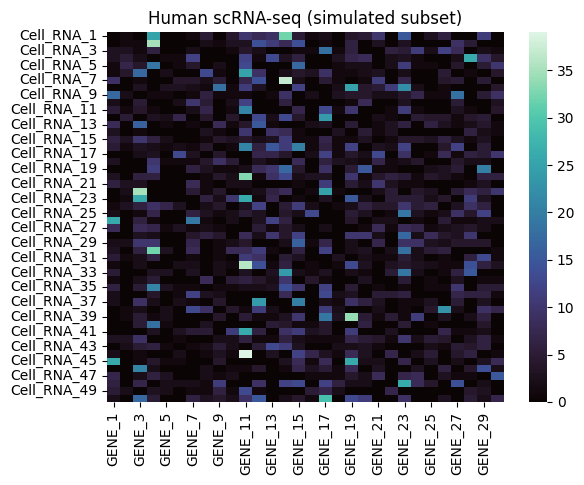

In [28]:
sns.heatmap(data['human_rna'].iloc[:50, :30], cmap='mako')
plt.title("Human scRNA-seq (simulated subset)")
plt.show()


In [29]:
def integrate_multiomics(rna, prot, meth):
    rna_z = StandardScaler().fit_transform(np.log1p(rna))
    prot_z = StandardScaler().fit_transform(np.log1p(prot))
    meth_z = StandardScaler().fit_transform(meth)
    integrated = np.concatenate([rna_z, prot_z, meth_z], axis=1)
    return integrated

human_integrated = integrate_multiomics(data['human_rna'], data['human_prot'], data['human_meth'])
print("Integrated human data shape:", human_integrated.shape)


Integrated human data shape: (500, 1450)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


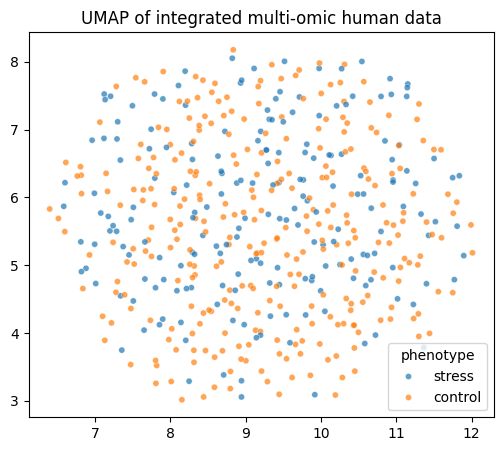

In [30]:
embedding = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.3).fit_transform(human_integrated)
meta = data['human_meta']
plt.figure(figsize=(6,5))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=meta['phenotype'], s=20, alpha=0.7)
plt.title("UMAP of integrated multi-omic human data")
plt.show()


In [31]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(human_integrated, meta['phenotype'])
pred = rf.predict(human_integrated)
print(classification_report(meta['phenotype'], pred))


              precision    recall  f1-score   support

     control       1.00      1.00      1.00       303
      stress       1.00      1.00      1.00       197

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [32]:
print("Sample ortholog mapping:")
display(data['ortholog_map'].head())


Sample ortholog mapping:


,human_gene,mouse_gene
0,GENE_1,MGENE_1
1,GENE_2,MGENE_2
2,GENE_3,MGENE_3
3,GENE_4,MGENE_4
4,GENE_5,MGENE_5


/tmp/ipython-input-983259315.py:153: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.issubdtype(df_counts.dtypes[0], np.integer):


Using top variable genes: (500, 500)


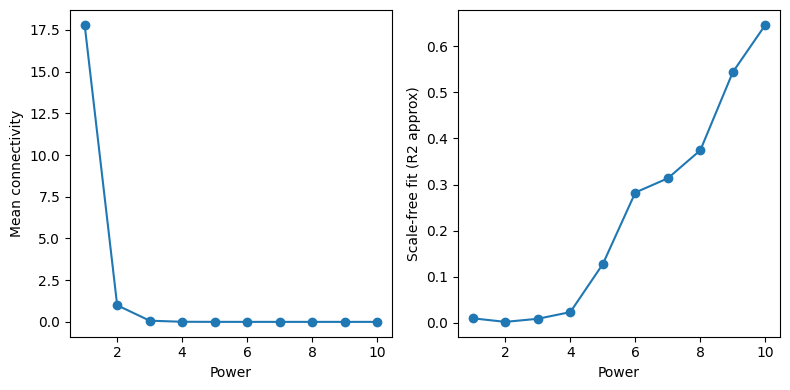

Chosen power: 6
Detected modules (non-noise): 0


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 400x300 with 0 Axes>

In [35]:
# ------------------ WGCNA-style pipeline (Python) ------------------
# running after simulating data (data['human_rna'], data['human_meta'] exist).

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import pearsonr
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Helper functions ----------

def top_variable_genes(df, top_n=1000):
    """Select top_n most variable genes (columns) from df (cells x genes)."""
    variances = df.var(axis=0)
    top = variances.sort_values(ascending=False).head(top_n).index
    return df.loc[:, top]

def compute_correlation_matrix(df):
    """Pearson correlation matrix between columns (genes)."""
    # df: samples x features
    return df.corr(method='pearson')

def pick_soft_threshold(corr_mat, powers=range(1, 11)):
    """
    For each candidate power, compute the scale-free topology fit (approximation).
    Returns DataFrame with power, mean_k, median_k, and R2_fit (approx).
    """
    out = []
    for p in powers:
        adj = np.abs(corr_mat) ** p
        # compute connectivity k for each node (sum of adjacency)
        k = adj.sum(axis=1) - np.diag(adj)  # subtract self if present (diagonal zeros usually)
        # follow WGCNA heuristic: fit log(p(k)) ~ log(k) [scale-free fit]
        # estimate degree distribution and linear fit R^2 as a proxy
        # build frequency table for degrees (bin)
        # to avoid zeros, add small epsilon
        eps = 1e-9
        kvals = k.values.flatten() + eps
        logk = np.log10(kvals)
        # compute histogram of degrees to approximate p(k)
        counts, bin_edges = np.histogram(logk, bins=20)
        mids = (bin_edges[:-1] + bin_edges[1:]) / 2
        nonzero = counts > 0
        if nonzero.sum() < 2:
            r2 = np.nan
        else:
            logcounts = np.log10(counts[nonzero])
            slope, intercept = np.polyfit(mids[nonzero], logcounts, 1)
            # compute R^2
            pred = slope * mids[nonzero] + intercept
            ss_res = np.sum((logcounts - pred)**2)
            ss_tot = np.sum((logcounts - logcounts.mean())**2)
            r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        out.append({
            'power': p,
            'mean_k': float(np.mean(kvals)),
            'median_k': float(np.median(kvals)),
            'R2_fit': float(r2) if np.isfinite(r2) else np.nan
        })
    return pd.DataFrame(out)

def adjacency_from_corr(corr_mat, power):
    """Adjacency = |cor|^power, with diagonal set to 0."""
    adj = np.abs(corr_mat.values) ** power
    np.fill_diagonal(adj, 0.0)
    return pd.DataFrame(adj, index=corr_mat.index, columns=corr_mat.columns)

def TOM_from_adjacency(adj_df):
    """
    Compute TOM (topological overlap matrix) from adjacency matrix.
    TOM_ij = (sum_u a_iu * a_ju + a_ij) / (min(k_i, k_j) + 1 - a_ij)
    where k_i = sum_u a_iu
    """
    A = adj_df.values
    # k: connectivity
    k = A.sum(axis=1)
    # numerator = A @ A + A (matrix multiplication)
    numerator = A.dot(A) + A
    # denominator matrix
    # denom_ij = min(k_i, k_j) + 1 - A_ij
    k_tile = np.minimum.outer(k, k)
    denom = k_tile + 1.0 - A
    # avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        TOM = numerator / denom
    # set diagonal to 1
    np.fill_diagonal(TOM, 1.0)
    TOM_df = pd.DataFrame(TOM, index=adj_df.index, columns=adj_df.columns)
    return TOM_df

def cluster_modules_from_tom(TOM_df, min_module_size=20, cut_height=None, method='average'):
    """
    Hierarchical clustering on TOM dissimilarity = 1 - TOM, then tree cut.
    If cut_height not provided, choose a heuristic (0.99 quantile of distances).
    Returns pandas Series mapping gene -> module_label (int).
    """
    diss = 1.0 - TOM_df.values
    # convert to condensed distance matrix for linkage
    # but linkage expects condensed form of pairwise distances
    iu = np.triu_indices_from(diss, k=1)
    condensed = diss[iu]
    Z = linkage(condensed, method=method)
    if cut_height is None:
        # heuristics: cut at 0.7 * max distance or median + some factor
        cut_height = np.percentile(condensed, 75) * 0.8
    labels = fcluster(Z, t=cut_height, criterion='distance')
    # map labels to contiguous module ids but drop tiny modules < min_module_size (assign 0)
    df_labels = pd.Series(labels, index=TOM_df.index)
    counts = df_labels.value_counts()
    keep_labels = counts[counts >= min_module_size].index
    filtered = df_labels.where(df_labels.isin(keep_labels), other=0)
    # convert to module ids 1..N (0 = noise)
    unique = [l for l in sorted(filtered.unique()) if l != 0]
    mapping = {0: 0}
    for new_idx, old in enumerate(unique, start=1):
        mapping[old] = new_idx
    mapped = filtered.map(mapping)
    return mapped.astype(int), Z

def module_eigengenes(df, module_series):
    """
    Compute module eigengenes = first principal component of module genes.
    df: samples x genes (DataFrame). module_series: gene->module int.
    Returns DataFrame samples x modules (ME_1, ME_2, ...)
    """
    modules = module_series.unique()
    modules = [m for m in modules if m != 0]  # ignore 0
    me_dict = {}
    for m in modules:
        genes = module_series[module_series == m].index.tolist()
        sub = df.loc[:, genes]
        # center
        subc = (sub - sub.mean(axis=0)) / (sub.std(axis=0).replace(0, 1))
        # PCA, first PC
        pca = PCA(n_components=1)
        pc1 = pca.fit_transform(subc.fillna(0).values)[:, 0]
        me_dict[f'ME{m}'] = pc1
    me_df = pd.DataFrame(me_dict, index=df.index)
    return me_df

# ---------- Pipeline ----------

def run_wgcna_like(df_counts, meta_df, top_n_genes=500, pick_powers=range(1,11), chosen_power=None,
                   min_module_size=20, plot=True):
    """
    df_counts: samples x genes (raw counts or continuous)
    meta_df: samples x traits (index must match df_counts.index)
    """
    # 1) filter to top variable genes and log-transform if counts
    if np.issubdtype(df_counts.dtypes[0], np.integer):
        mat = np.log1p(df_counts)
    else:
        mat = df_counts.copy()
    mat_tv = top_variable_genes(mat, top_n=top_n_genes)
    print("Using top variable genes:", mat_tv.shape)

    # 2) correlation matrix
    corr = compute_correlation_matrix(mat_tv)

    # 3) pick soft-threshold
    thresh_df = pick_soft_threshold(corr, powers=pick_powers)
    if plot:
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.plot(thresh_df['power'], thresh_df['mean_k'], '-o')
        plt.xlabel('Power'); plt.ylabel('Mean connectivity')
        plt.subplot(1,2,2)
        plt.plot(thresh_df['power'], thresh_df['R2_fit'], '-o')
        plt.xlabel('Power'); plt.ylabel('Scale-free fit (R2 approx)')
        plt.tight_layout()
        plt.show()
    if chosen_power is None:
        # choose first power with R2_fit > 0.7 or fallback to 6
        good = thresh_df[thresh_df['R2_fit'] > 0.7]
        chosen_power = int(good['power'].iloc[0]) if len(good) > 0 else 6
    print("Chosen power:", chosen_power)

    # 4) adjacency and TOM
    adj = adjacency_from_corr(corr, power=chosen_power)
    TOM = TOM_from_adjacency(adj)
    dissTOM = 1.0 - TOM

    # 5) clustering & module detection
    modules, Z = cluster_modules_from_tom(TOM, min_module_size=min_module_size)
    n_modules = len([m for m in modules.unique() if m!=0])
    print("Detected modules (non-noise):", n_modules)

    # 6) module eigengenes
    me_df = module_eigengenes(mat_tv, modules)

    # 7) module-trait correlation
    # convert categorical traits into numeric if needed
    trait_df = meta_df.copy()
    # map phenotype to numeric if exists
    for col in trait_df.columns:
        if trait_df[col].dtype == object or str(trait_df[col].dtype).startswith('category'):
            # map categories to integers (simple)
            trait_df[col] = pd.Categorical(trait_df[col]).codes

    common_idx = mat_tv.index.intersection(trait_df.index)
    me_df_common = me_df.loc[common_idx]
    trait_df_common = trait_df.loc[common_idx]

    corr_mt = me_df_common.corrwith(trait_df_common.iloc[:,0], axis=0) if trait_df_common.shape[1]==1 else me_df_common.corrwith(trait_df_common.iloc[:,0], axis=0)
    # compute full correlation matrix (ME x traits)
    corr_matrix = pd.DataFrame(index=me_df_common.columns, columns=trait_df_common.columns, dtype=float)
    pval_matrix = pd.DataFrame(index=me_df_common.columns, columns=trait_df_common.columns, dtype=float)
    for me in me_df_common.columns:
        for tr in trait_df_common.columns:
            r, p = pearsonr(me_df_common[me], trait_df_common[tr])
            corr_matrix.loc[me, tr] = r
            pval_matrix.loc[me, tr] = p

    if plot:
        plt.figure(figsize=(max(4, 0.6*len(me_df.columns)), max(3, 0.6*trait_df_common.shape[1])))
        sns.heatmap(corr_matrix.astype(float), annot=True, cmap='vlag', center=0)
        plt.title('Module Eigengene vs Trait correlations (r)')
        plt.show()

    # return results
    return {
        'mat_tv': mat_tv,
        'corr': corr,
        'adjacency': adj,
        'TOM': TOM,
        'dissTOM': dissTOM,
        'modules': modules,
        'linkage_Z': Z,
        'module_eigengenes': me_df,
        'module_trait_corr': corr_matrix,
        'module_trait_pval': pval_matrix
    }

# ---------- Example run on simulated human_rna & human_meta ----------
# Ensure 'data' dict exists (run your simulation cell first)
if 'data' not in globals():
    raise RuntimeError("Please run the simulation cell first to create `data` dictionary.")

# Use a modest number of genes to keep runtime low in Colab (e.g., 500)
results = run_wgcna_like(
    df_counts = data['human_rna'],
    meta_df = data['human_meta'],
    top_n_genes = 500,        # reduce for speed; increase for real analyses
    pick_powers = range(1,11),
    chosen_power = None,      # let function pick
    min_module_size = 20,
    plot = True
)

# Quick summaries
print("Module counts (including 0=noise):")
print(results['modules'].value_counts().sort_index())
print("\nModule-trait correlations:")
display(results['module_trait_corr'])
